## Тестовое задание для HR-tech стартапа **Sfera**

**Задача**: классифицировать описания вакансий по 3 классам относительно возможности удаленной работы:
* "-1" точно не удаленная работа;
* "0" текст вакансии не про удаленную работу;
* "1" удаленная работа возможна.

**Дано**: корпус из 1368 размеченных текстов.

**Реализовано** стандартное решение: эмбеддинги текстов созданы с помощью предобученного трансформера ([*DeepPavlov/rubert-base-cased-sentence*](https://huggingface.co/DeepPavlov/rubert-base-cased-sentence)), далее над эмбеддингами токена класса (CLS) обучена логистическая регрессия.


### Импорт библиотек

In [ ]:
!pip install transformers
!pip install sentencepiece

import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    ConfusionMatrixDisplay, 
    multilabel_confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import notebook

RANDOM_STATE=42

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 11.7 MB/s 
     |████████████████████████████████| 596 kB 14.5 MB/s 
     |████████████████████████████████| 6.6 MB 38.8 MB/s 
     |████████████████████████████████| 101 kB 9.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 17.1 MB/s 


Будем использовать предобученную модель DeepPavlov/rubert-base-cased-sentence.
* Модель представляет собой fine-tuned версию RuBERT;
* RuBERT является "дочкой" мультиязычного BERT и дообучалась на русской Википедии и новостных сайтах.

Инициализируем модель и токенизатор.

In [ ]:
model_name = 'DeepPavlov/rubert-base-cased-sentence'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

### Подготовка данных

Загружаем предоставленный датасет в `pandas.DataFrame` напрямую из Google Таблиц ([ссылка](https://docs.google.com/spreadsheets/d/18VBo1v7THmxk-Z6W02jyRFuPKGVRc-b93Ixta1cerKQ/edit#gid=0))

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/18VBo1v7THmxk-Z6W02jyRFuPKGVRc-b93Ixta1cerKQ/export?format=csv&gid=0&range=A1:D1369'
data = pd.read_csv(url)
data.shape

(1368, 4)

In [ ]:
data.head(20)

,ID,Найдено в,Текст,Удаленка
0,67259437,Описание,Желание работать на всесезонной базе отдыха кл...,0
1,67542900,Описание,"График работы: 5/2, возможна удаленная работа ...",1
2,66953697,Описание,6.Ежедневная проверка классных и домашних рабо...,0
3,67381114,Описание,Работа РЯДОМ С ДОМОМ,-1
4,67624820,Описание,Удаленная работа,1
5,67132452,Описание,Работа РЯДОМ С ДОМОМ,-1
6,67227407,Описание,▲несмотря на удалённую работу - соблюдать срок...,1
7,67227407,Описание,▲ частично удалённая работа,1
8,67132317,Описание,- испытательный срок 3 месяца (после успешного...,1
9,67511126,Описание,"Режим работы: пн - чт 09:00 - 18:00, пт 09:00 ...",1


Для удобства переименовываем столбцы и выбрасываем "ID" и "Найдено в", так как в нашей задаче они не понадобятся.

In [ ]:
data.columns = ['id', 'desc', 'text', 'label']
data.drop(['desc', 'id'], axis=1, inplace=True)

In [ ]:
data['text'].apply(len).describe()

count    1368.000000
mean       62.515351
std        50.676749
min         8.000000
25%        29.000000
50%        50.000000
75%        81.000000
max       699.000000
Name: text, dtype: float64

In [ ]:
data['label'] = data['label'].map({-1:'not_distant', 0:'unknown', 1:'distant'})

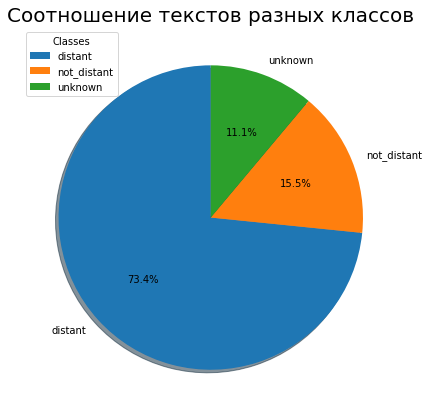

In [ ]:
labels = data['label'].value_counts().index
fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.pie(data['label'].value_counts(), 
        labels=labels,
        autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Соотношение текстов разных классов', fontsize=20)
plt.legend(title='Classes')
plt.show()

**Вывод по диаграмме:** у нас присутствует дисбаланс классов, т.к. больше всего текстов с возможностью удаленной работы. Учтём это при разделении на обучающую и тестовую выборки.

### Создание эмбеддингов

Сперва токенизируем наши тексты, используя словарь от BERT'а. Добавим специальные токены (101 и 102), обозначающие начало и конец текста.

In [ ]:
tokenized = data['text'].apply(
    lambda x: tokenizer.encode(x, truncation=True, max_length=512, 
                               add_special_tokens=True, padding=True))
tokenized.shape

(1368,)

In [ ]:
tokenized[0]

[101,
 95634,
 12313,
 1469,
 84738,
 19924,
 1700,
 13398,
 21992,
 75238,
 10298,
 1469,
 5345,
 15042,
 869,
 107509,
 87807,
 1455,
 102]

Далее приведем все тексты к одинаковой длине (равной максимальной длине текста в корпусе), дополнив более короткие тексты нулями.

In [ ]:
max_len = max(tokenized.apply(len))
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)
padded.shape

(1368, 99)

Далее непосредственно создание эмбеддингов - передаём в модель тексты батчами по 200 шт.

In [ ]:
batch_size = 200
embeddings = []
for batch_number in notebook.tqdm(range(padded.shape[0] // batch_size)):
        start = batch_size*batch_number
        end = batch_size*(batch_number + 1)

        batch = torch.LongTensor(padded[start:end]) 
        attention_mask_batch = torch.LongTensor(attention_mask[start:end])

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())
    
# special "crutch" for values not included in batches
last_batch = torch.LongTensor(padded[-(padded.shape[0] % batch_size):])
attention_mask_last_batch = torch.LongTensor(attention_mask[-(padded.shape[0] % batch_size):])
with torch.no_grad():
    batch_embeddings = model(last_batch, attention_mask=attention_mask_last_batch)
embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/6 [00:00<?, ?it/s]

Полученные эмбеддинги конкатенируем в одну переменную, получаем numpy-массив, в котором каждый текст представлен 768-мерным вектором.

Вектор с целевыми метками подвергаем one-hot-encoding кодированию, т.к. у нас задача мультиклассовой классификации.

In [ ]:
X = np.concatenate(embeddings)
y = pd.get_dummies(data['label'])
X.shape, y.shape

((1368, 768), (1368, 3))

Вектор признаков и вектор с метками готовы к обучению: разделяем на обучающую и тестовую выборки в соотношении. Под тест отводим 25% текстов.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, 
                                                    shuffle=True, random_state=RANDOM_STATE)
X_train.shape, X_test.shape

((1026, 768), (342, 768))

Проверим, что в векторе целевых меток в обучающей выборке сохранился исходный дисбаланс классов (73/11/15%).

In [ ]:
y_train.value_counts(normalize=True)

distant  not_distant  unknown
1        0            0          0.733918
0        1            0          0.154971
         0            1          0.111111
dtype: float64

### Обучение модели

Так как нам необходима multiclass классификация, будем использовать технику "один класс против остальных". Таким образом логистическая регрессия будет обучаться трижды, стараясь отличать каждый из 3-х классов от двух других.

In [ ]:
lr = LogisticRegression(random_state=RANDOM_STATE, verbose=2)
clf = OneVsRestClassifier(lr, n_jobs=-1)

In [ ]:
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(random_state=42, verbose=2),
                    n_jobs=-1)

In [ ]:
preds = clf.predict(X_test)

Просмотрим отчет о качестве классификации. Здесь наши классы представлены следующими метками:
* 0 - точно не удаленная работа;
* 1 - текст не про удаленную работу;
* 2 - возможна удаленная работа.

In [ ]:
print(classification_report(preds, y_test, target_names=y_test.columns))

              precision    recall  f1-score   support

     distant       0.98      0.94      0.96       264
 not_distant       0.81      0.96      0.88        45
     unknown       0.66      0.81      0.72        31

   micro avg       0.92      0.93      0.92       340
   macro avg       0.82      0.90      0.85       340
weighted avg       0.93      0.93      0.93       340
 samples avg       0.92      0.91      0.91       340



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = multilabel_confusion_matrix(preds, y_test) / y_test.shape[0] * 100

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=16):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    heatmap = sns.heatmap(df_cm, annot=True,  cbar=False, ax=axes)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label', fontsize=16)
    axes.set_xlabel('Predicted label', fontsize=16)
    axes.set_title("Для класса " + class_label, fontsize=18)
    plt.suptitle('Нормализованные матрицы ошибок (в %)', y=1.08, fontsize=22)

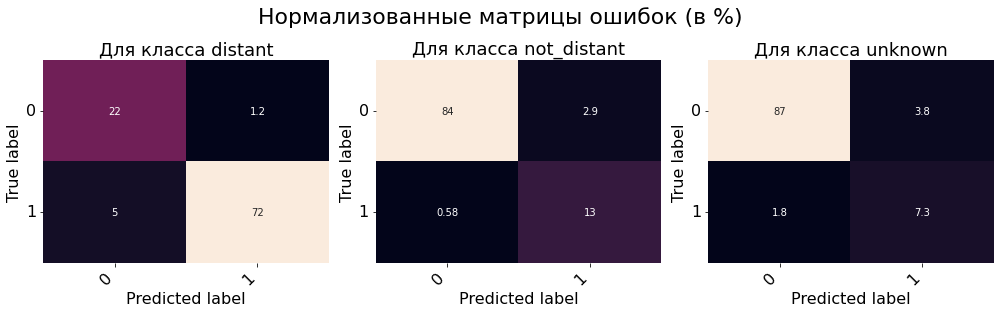

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, y_test.columns):
    print_confusion_matrix(cfs_matrix, axes, label, [0, 1])
    
fig.tight_layout()
plt.show()

### Вывод

Мы обучили логистическую регрессию в задаче классификации текстов вакансий на 3 класса:
* **not_distant** - точно не удаленная работа;
* **unknown** - текст не про удаленную работу;
* **distant** - возможна удаленная работа.

Наиболее точно и полно модель определяет класс distant, вероятно в описаниях таких вакансий есть какие-то характерные паттерны, которые хорошо отражены в 768-мерных эмбеддингах этих текстов. Либо потому что это наиболее многочисленный класс при обучении.

При том и ошибается модель чаще всего на классе distant. Как видим из матрицы ошибок - 5% текстов из тестовой выборки модель упустила, хотя они действительно были про возможность удаленной работы.